In [1]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Load lib

In [3]:
import re
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import optuna

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from torch.utils.data import (TensorDataset,
                              Dataset, 
                              random_split, 
                              DataLoader, 
                              RandomSampler, 
                              SequentialSampler)

from transformers import (get_linear_schedule_with_warmup,
                          AutoModelForSequenceClassification,
                          get_cosine_schedule_with_warmup,


                          AdamW, 
                          AutoTokenizer)

from sklearn.metrics import (f1_score, 
                             precision_score,
                             recall_score)


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [4]:
import random
import numpy as np
seed_val = 42
random.seed(42)

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

## Load data

In [5]:
!gdown --id 13EUGzAMaP5g_p8DqANI7Z2M1iAvW8vDz

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=13EUGzAMaP5g_p8DqANI7Z2M1iAvW8vDz
To: /content/data_v2_19_oct.csv
100% 46.3M/46.3M [00:00<00:00, 109MB/s] 


### Check cuda

In [6]:
df = pd.read_csv('/content/data_v2_19_oct.csv')

In [7]:
df.head()

,pair_id,name_1,name_2,is_duplicate,name_1_upd,name_2_upd
0,1,Iko Industries Ltd.,"Enormous Industrial Trade Pvt., Ltd.",0,Iko,Enormous Trade
1,2,Apcotex Industries Ltd.,Technocraft Industries (India) Ltd.,0,Apcotex,Technocraft India
2,3,"Rishichem Distributors Pvt., Ltd.",Dsa,0,Rishichem Distributors,Dsa
3,4,Powermax Rubber Factory,Co. One,0,Powermax Factory,One
4,5,Tress A/S,Longyou Industries Park Zhejiang,0,Tress,Longyou Park Zhejiang


## Resample data

In [8]:
# Class count
count_class_0, count_class_1 = df.is_duplicate.value_counts()

# Divide by class
df_class_0 = df[df['is_duplicate'] == 0]
df_class_1 = df[df['is_duplicate'] == 1]

Random under-sampling:
0    3658
1    3658
Name: is_duplicate, dtype: int64


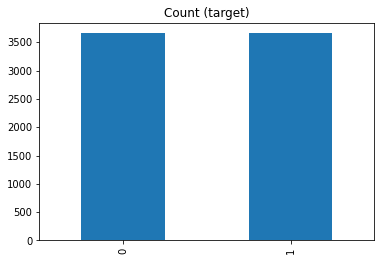

In [9]:
df_class_0_under = df_class_0.sample(count_class_1)
df = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df.is_duplicate.value_counts())

df.is_duplicate.value_counts().plot(kind='bar', title='Count (target)');

In [10]:
df = df.reset_index()
df.head()

,index,pair_id,name_1,name_2,is_duplicate,name_1_upd,name_2_upd
0,484251,484252,R M Trading Co.,Dht Trading Development Ltd.,0,R M,Dht Development
1,202991,202992,Prema Tyre Supplies,Trp International Inc.,0,Prema Tyre Supplies,Trp
2,396820,396821,"Sridhar Engineering And Rubber Products Pvt., ...",Miroad Rubber Usa,0,Sridhar Engineering And,Miroad Usa
3,196795,196796,Halliburton Latin America S.A. Llc,Fama Latin America S A,0,Halliburton Latin America,Fama Latin America
4,299280,299281,New Vision Rubber & Plastic Technology Sdn Bhd,Bdp International,0,New Vision Plastic Technology Sdn Bhd,Bdp


In [11]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Thera are  %d GPU(s) available.' % torch.cuda.device_count())
    print(torch.cuda.get_device_name(device=None))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Thera are  1 GPU(s) available.
Tesla T4


## Create model Deberta_base

In [12]:
model_name = "microsoft/deberta-base"
model = AutoModelForSequenceClassification.from_pretrained(model_name, 
                                                          num_labels=2,
                                                          output_attentions = False,
                                                          output_hidden_states = False,).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.weight', 'classi

In [13]:
def objective(trial: optuna.Trial):

    model_name = "microsoft/deberta-base"
    model = AutoModelForSequenceClassification.from_pretrained(model_name, 
                                                              num_labels=2,
                                                              output_attentions = False,
                                                              output_hidden_states = False,).to(device)

    max_length = trial.suggest_int("max_length", 10, 35)
    batch_size = trial.suggest_int("batch_size", 64, 256)
    epochs = trial.suggest_int("epochs", 1, 4)

    tokenizer.model_max_length = max_length

    df['sentences'] = df.name_1 + tokenizer.sep_token + df.name_2
    sentences = df.sentences.values
    labels = df.is_duplicate.values

    input_ids = []
    attention_masks = []

    for sent in tqdm(sentences):
      
        encoded_dict = tokenizer.encode_plus(
            sent, 
            add_special_tokens = True,
            max_length = max_length,
            pad_to_max_length = True,
            return_attention_mask = True,
            return_tensors = 'pt'
        )
        
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    y = torch.tensor(labels)
    df_labels = df[['is_duplicate']] 
    y_train, y_test = train_test_split(df_labels, shuffle=True, stratify=df_labels, train_size = 0.65)
    train_index, test_inex = y_train.index, y_test.index
    train_dataset = TensorDataset(input_ids[train_index], attention_masks[train_index], y[train_index])
    test_dataset = TensorDataset(input_ids[test_inex], attention_masks[test_inex], y[test_inex])

    
    train_dataloader = DataLoader(
        train_dataset,
        sampler = RandomSampler(train_dataset),
        batch_size = batch_size
    )

    test_dataloader = DataLoader(
        test_dataset,
        sampler = SequentialSampler(test_dataset),
        batch_size = batch_size
    )                          
        

    optimizer = AdamW( model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
    )

    

    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup( optimizer,
                                              num_warmup_steps=0,
                                              num_training_steps= total_steps)
    
    for epoch_i in (range(1, epochs + 1)):
      total_train_loss = 0
      model.train()
      
      for batch in tqdm(train_dataloader):
          
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)
          
          model.zero_grad()
          
          
          res = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels = b_labels)
              
          loss= res['loss']
          logits = res['logits']
          
          total_train_loss += loss.item()
          
          loss.backward()
          
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
          
          
          optimizer.step()
          scheduler.step()
          
      avg_train_loss = total_train_loss / len(train_dataloader)
      
      model.eval()
      
      total_eval_accuracy = 0
      total_eval_loss = 0
      nb_eval_steps = 0
      
      list_of_logits = None
      list_of_label_ids = None

      for batch in test_dataloader:
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)
          
          with torch.no_grad():
              res = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels = b_labels) 
              
              loss= res['loss']
              logits = res['logits']
              
          total_eval_loss += loss.item()

          logits = logits.detach().to('cpu')
          label_ids = b_labels.to('cpu')

          if list_of_logits is None:
              list_of_logits = logits
              list_of_label_ids = label_ids
          
          else:
              list_of_logits = torch.cat((list_of_logits, logits))
              list_of_label_ids = torch.cat((list_of_label_ids, label_ids))
          
      pred  = torch.Tensor(list_of_logits).argmax(dim=1).to('cpu')

      f1_ = f1_score(list_of_label_ids, pred)
      precision = precision_score(list_of_label_ids, pred)
      recall = recall_score(list_of_label_ids, pred)
      avg_val_loss = total_eval_loss / len(test_dataloader)

      return f1_

In [14]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)

[I 2022-10-31 16:42:57,209] A new study created in memory with name: no-name-8e6ccf2e-cd70-4eae-8a87-e871076e3ad1
Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initiali

  0%|          | 0/7316 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This impleme

  0%|          | 0/21 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tensor(scale, dtype=query_layer.dtype)
/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p2c_att = torch.matmul(key_layer, torch.tensor(pos_query_layer.transpose(-1, -2), dtype=key_layer.dtype))
[I 2022-10-31 16:43:43,507] Trial 0 finished with value: 0.8619854721549637 and parameters: {'max_length': 25, 'batch_size': 229, 'epochs': 4}. Best is trial 0 with value: 0.8619854721549637.
Some weights of the model checkpoint at microsoft

  0%|          | 0/7316 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tensor(scale, dtype=query_layer.dtype)
/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p2c_att = torch.matmul(key_layer, torch.tensor(pos_query_layer.transpose(-1, -2), dtype=key_layer.dtype))
[I 2022-10-31 16:44:52,278] Trial 1 finished with value: 0.9548387096774194 and parameters: {'max_length': 34, 'batch_size': 172, 'epochs': 2}. Best is trial 1 with value: 0.9548387096774194.
Some weights of the model checkpoint at microsoft

  0%|          | 0/7316 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/41 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tensor(scale, dtype=query_layer.dtype)
/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p2c_att = torch.matmul(key_layer, torch.tensor(pos_query_layer.transpose(-1, -2), dtype=key_layer.dtype))
[I 2022-10-31 16:45:54,194] Trial 2 finished with value: 0.9188298310671611 and parameters: {'max_length': 31, 'batch_size': 117, 'epochs': 2}. Best is trial 1 with value: 0.9548387096774194.
Some weights of the model checkpoint at microsoft

  0%|          | 0/7316 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/27 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tensor(scale, dtype=query_layer.dtype)
/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p2c_att = torch.matmul(key_layer, torch.tensor(pos_query_layer.transpose(-1, -2), dtype=key_layer.dtype))
[I 2022-10-31 16:46:15,697] Trial 3 finished with value: 0.7294658242389431 and parameters: {'max_length': 16, 'batch_size': 178, 'epochs': 1}. Best is trial 1 with value: 0.9548387096774194.
Some weights of the model checkpoint at microsoft

  0%|          | 0/7316 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tensor(scale, dtype=query_layer.dtype)
/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p2c_att = torch.matmul(key_layer, torch.tensor(pos_query_layer.transpose(-1, -2), dtype=key_layer.dtype))
[I 2022-10-31 16:47:54,235] Trial 4 finished with value: 0.9374763167866615 and parameters: {'max_length': 22, 'batch_size': 170, 'epochs': 1}. Best is trial 1 with value: 0.9548387096774194.
Some weights of the model checkpoint at microsoft

  0%|          | 0/7316 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/29 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tensor(scale, dtype=query_layer.dtype)
/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p2c_att = torch.matmul(key_layer, torch.tensor(pos_query_layer.transpose(-1, -2), dtype=key_layer.dtype))
[I 2022-10-31 16:48:28,431] Trial 5 finished with value: 0.9531490015360983 and parameters: {'max_length': 30, 'batch_size': 164, 'epochs': 3}. Best is trial 1 with value: 0.9548387096774194.
Some weights of the model checkpoint at microsoft

  0%|          | 0/7316 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/29 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tensor(scale, dtype=query_layer.dtype)
/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p2c_att = torch.matmul(key_layer, torch.tensor(pos_query_layer.transpose(-1, -2), dtype=key_layer.dtype))
[I 2022-10-31 16:50:11,923] Trial 6 finished with value: 0.9212893553223389 and parameters: {'max_length': 19, 'batch_size': 165, 'epochs': 4}. Best is trial 1 with value: 0.9548387096774194.
Some weights of the model checkpoint at microsoft

  0%|          | 0/7316 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/70 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tensor(scale, dtype=query_layer.dtype)
/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p2c_att = torch.matmul(key_layer, torch.tensor(pos_query_layer.transpose(-1, -2), dtype=key_layer.dtype))
[I 2022-10-31 16:51:46,181] Trial 7 finished with value: 0.9023255813953488 and parameters: {'max_length': 14, 'batch_size': 68, 'epochs': 1}. Best is trial 1 with value: 0.9548387096774194.
Some weights of the model checkpoint at microsoft/

  0%|          | 0/7316 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/43 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tensor(scale, dtype=query_layer.dtype)
/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p2c_att = torch.matmul(key_layer, torch.tensor(pos_query_layer.transpose(-1, -2), dtype=key_layer.dtype))
[I 2022-10-31 16:53:23,172] Trial 8 finished with value: 0.9452054794520548 and parameters: {'max_length': 21, 'batch_size': 113, 'epochs': 2}. Best is trial 1 with value: 0.9548387096774194.
Some weights of the model checkpoint at microsoft

  0%|          | 0/7316 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tensor(scale, dtype=query_layer.dtype)
/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p2c_att = torch.matmul(key_layer, torch.tensor(pos_query_layer.transpose(-1, -2), dtype=key_layer.dtype))
[I 2022-10-31 16:54:59,738] Trial 9 finished with value: 0.850177304964539 and parameters: {'max_length': 22, 'batch_size': 238, 'epochs': 1}. Best is trial 1 with value: 0.9548387096774194.
Some weights of the model checkpoint at microsoft/

  0%|          | 0/7316 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/23 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tensor(scale, dtype=query_layer.dtype)
/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p2c_att = torch.matmul(key_layer, torch.tensor(pos_query_layer.transpose(-1, -2), dtype=key_layer.dtype))
[I 2022-10-31 16:56:48,275] Trial 10 finished with value: 0.9513023782559457 and parameters: {'max_length': 33, 'batch_size': 210, 'epochs': 3}. Best is trial 1 with value: 0.9548387096774194.
Some weights of the model checkpoint at microsof

  0%|          | 0/7316 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/38 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tensor(scale, dtype=query_layer.dtype)
/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p2c_att = torch.matmul(key_layer, torch.tensor(pos_query_layer.transpose(-1, -2), dtype=key_layer.dtype))
[I 2022-10-31 16:58:34,032] Trial 11 finished with value: 0.9620449264136328 and parameters: {'max_length': 29, 'batch_size': 126, 'epochs': 3}. Best is trial 11 with value: 0.9620449264136328.
Some weights of the model checkpoint at microso

  0%|          | 0/7316 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/39 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tensor(scale, dtype=query_layer.dtype)
/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p2c_att = torch.matmul(key_layer, torch.tensor(pos_query_layer.transpose(-1, -2), dtype=key_layer.dtype))
[I 2022-10-31 16:59:13,954] Trial 12 finished with value: 0.9693486590038314 and parameters: {'max_length': 35, 'batch_size': 125, 'epochs': 3}. Best is trial 12 with value: 0.9693486590038314.
Some weights of the model checkpoint at microso

  0%|          | 0/7316 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/40 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tensor(scale, dtype=query_layer.dtype)
/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p2c_att = torch.matmul(key_layer, torch.tensor(pos_query_layer.transpose(-1, -2), dtype=key_layer.dtype))
[I 2022-10-31 17:00:57,569] Trial 13 finished with value: 0.9213938411669369 and parameters: {'max_length': 27, 'batch_size': 121, 'epochs': 3}. Best is trial 12 with value: 0.9693486590038314.
Some weights of the model checkpoint at microso

  0%|          | 0/7316 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/51 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tensor(scale, dtype=query_layer.dtype)
/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p2c_att = torch.matmul(key_layer, torch.tensor(pos_query_layer.transpose(-1, -2), dtype=key_layer.dtype))
[I 2022-10-31 17:02:48,476] Trial 14 finished with value: 0.9687010954616588 and parameters: {'max_length': 35, 'batch_size': 95, 'epochs': 3}. Best is trial 12 with value: 0.9693486590038314.


In [15]:
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)



Number of finished trials: 15
Best trial: {'max_length': 35, 'batch_size': 125, 'epochs': 3}


In [16]:
optuna.visualization.plot_optimization_history(study)

In [17]:
optuna.visualization.plot_param_importances(study)

In [19]:
optuna.visualization.plot_edf(study)
